Aim: To find out the disparity of selection by the model on sensitive features such as sex, race, marital status 

Dataset: Dataset has been taken from kaggle (https://www.kaggle.com/datasets/antimoni/metabolic-syndrome/data)

Approach: Train a model (Logistic Regression & Random Forrest Classifier) on the processed data to evaluate its selection disparity using fairlearn library.

Result: Find a model which balances the trade offs between accuracy and selection disparity of sensitive features.

1) Import the necessary libraries.

In [85]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from fairlearn.preprocessing import CorrelationRemover
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics as skm
from sklearn.metrics import classification_report, confusion_matrix
from fairlearn.datasets import fetch_adult
from fairlearn.metrics import (
    MetricFrame,
    count,
    plot_model_comparison,
    selection_rate,
    selection_rate_difference,
)
from fairlearn.reductions import DemographicParity, ErrorRate, GridSearch

2) Load the data.

In [86]:
data = pd.read_csv("Metabolic Syndrome.csv")
data

,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,0
1,62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,0
2,62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,0
3,62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,0
4,62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2396,71901,48,Female,Married,1000.0,Other,NaN,59.7,0,22.11,5.8,152,57,107,0
2397,71904,30,Female,Single,2000.0,Asian,NaN,18.0,0,2.90,7.9,91,90,91,0
2398,71909,28,Male,Single,800.0,MexAmerican,100.8,29.4,0,2.78,6.2,99,47,84,0
2399,71911,27,Male,Married,8200.0,MexAmerican,106.6,31.3,0,4.15,6.2,100,41,124,1


3) Get summary of the data.

In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   seqn               2401 non-null   int64  
 1   Age                2401 non-null   int64  
 2   Sex                2401 non-null   object 
 3   Marital            2193 non-null   object 
 4   Income             2284 non-null   float64
 5   Race               2401 non-null   object 
 6   WaistCirc          2316 non-null   float64
 7   BMI                2375 non-null   float64
 8   Albuminuria        2401 non-null   int64  
 9   UrAlbCr            2401 non-null   float64
 10  UricAcid           2401 non-null   float64
 11  BloodGlucose       2401 non-null   int64  
 12  HDL                2401 non-null   int64  
 13  Triglycerides      2401 non-null   int64  
 14  MetabolicSyndrome  2401 non-null   int64  
dtypes: float64(5), int64(7), object(3)
memory usage: 281.5+ KB


In [88]:
data['Marital'].unique()

array(['Single', 'Married', 'Widowed', 'Divorced', nan, 'Separated'],
      dtype=object)

In [89]:
data.describe()

,seqn,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
count,2401.000000,2401.000000,2284.000000,2316.000000,2375.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000
mean,67030.674302,48.691795,4005.253940,98.307254,28.702189,0.154102,43.626131,5.489046,108.247813,53.369429,128.125364,0.342357
std,2823.565114,17.632852,2954.032186,16.252634,6.662242,0.422780,258.272829,1.439358,34.820657,15.185537,95.322477,0.474597
min,62161.000000,20.000000,300.000000,56.200000,13.400000,0.000000,1.400000,1.800000,39.000000,14.000000,26.000000,0.000000
25%,64591.000000,34.000000,1600.000000,86.675000,24.000000,0.000000,4.450000,4.500000,92.000000,43.000000,75.000000,0.000000
50%,67059.000000,48.000000,2500.000000,97.000000,27.700000,0.000000,7.070000,5.400000,99.000000,51.000000,103.000000,0.000000
75%,69495.000000,63.000000,6200.000000,107.625000,32.100000,0.000000,13.690000,6.400000,110.000000,62.000000,150.000000,1.000000
max,71915.000000,80.000000,9000.000000,176.000000,68.700000,2.000000,5928.000000,11.300000,382.000000,156.000000,1562.000000,1.000000


In [90]:
data.isna().sum()

seqn                   0
Age                    0
Sex                    0
Marital              208
Income               117
Race                   0
WaistCirc             85
BMI                   26
Albuminuria            0
UrAlbCr                0
UricAcid               0
BloodGlucose           0
HDL                    0
Triglycerides          0
MetabolicSyndrome      0
dtype: int64

4) Handle null/NaN values.

In [91]:
data['Income'].fillna(value=data['Income'].mean(), inplace=True)
data['WaistCirc'].fillna(value=data['WaistCirc'].mean(), inplace=True)
data['BMI'].fillna(value=data['BMI'].mean(), inplace=True)
data['Marital'] = data['Marital'].fillna(random.choice(data['Marital']))

C:\Users\vinay\AppData\Local\Temp\ipykernel_26172\3585137555.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Income'].fillna(value=data['Income'].mean(), inplace=True)
C:\Users\vinay\AppData\Local\Temp\ipykernel_26172\3585137555.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 

5) Create a set of sensitive features.

In [92]:
sensitive_data = pd.DataFrame({
    "Sex": data['Sex'],
    "Race": data['Race'],
    "Marital": data['Marital']
})

sensitive_data

,Sex,Race,Marital
0,Male,White,Single
1,Female,White,Married
2,Male,Asian,Single
3,Female,Black,Single
4,Male,Asian,Married
...,...,...,...
2396,Female,Other,Married
2397,Female,Asian,Single
2398,Male,MexAmerican,Single
2399,Male,MexAmerican,Married


6) Visualize the data.

C:\Users\vinay\AppData\Local\Temp\ipykernel_26172\1124108190.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = data, y = column, ax = ax[i][1], palette = 'viridis', order = data[column].value_counts().index)
C:\Users\vinay\AppData\Local\Temp\ipykernel_26172\1124108190.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = data, y = column, ax = ax[i][1], palette = 'viridis', order = data[column].value_counts().index)
C:\Users\vinay\AppData\Local\Temp\ipykernel_26172\1124108190.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.c

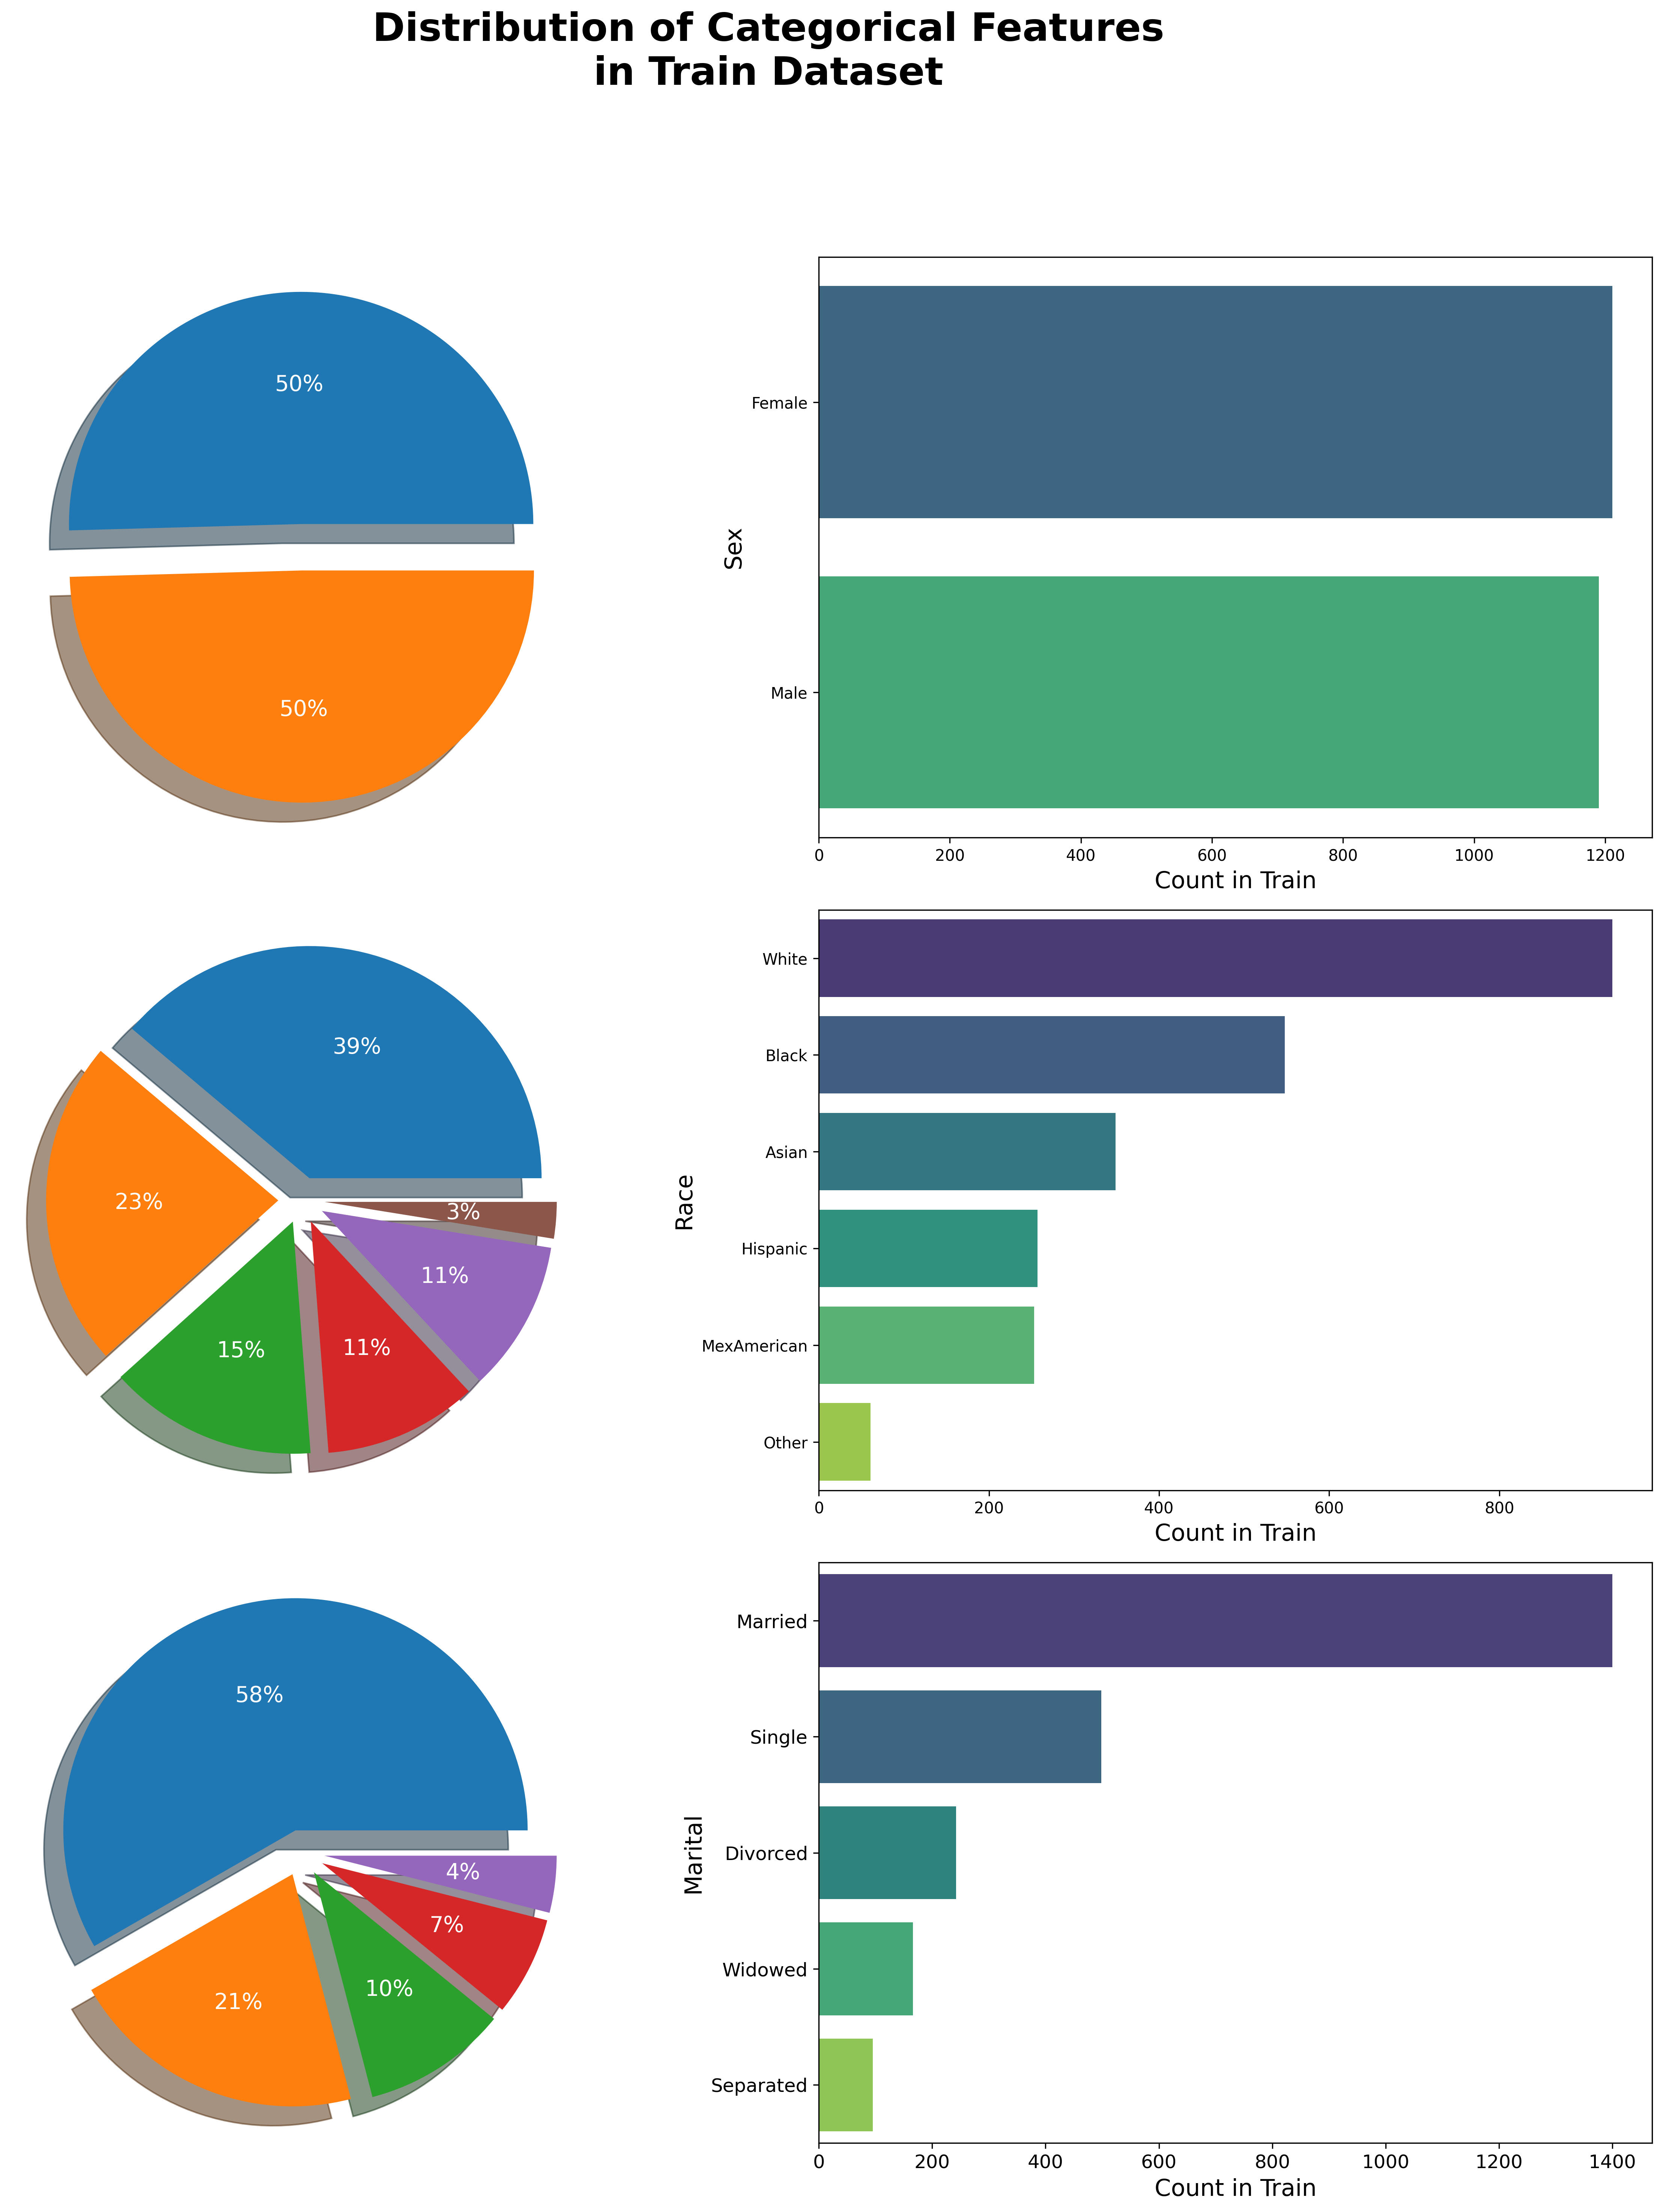

In [93]:
fig, ax = plt.subplots(3, 2, figsize = (16, 20), dpi = 300)

for i, column in enumerate(sensitive_data):

    ax[i][0].pie(
        data[column].value_counts(), 
        shadow = True, 
        explode = [.1 for i in range(data[column].nunique())], 
        autopct = '%1.f%%',
        textprops = {'size' : 14, 'color' : 'white'}
    )

    sns.countplot(data = data, y = column, ax = ax[i][1], palette = 'viridis', order = data[column].value_counts().index)
    ax[i][1].yaxis.label.set_size(20)
    plt.yticks(fontsize = 12)
    ax[i][1].set_xlabel('Count in Train', fontsize = 15)
    ax[i][1].set_ylabel(f'{column}', fontsize = 15)
    plt.xticks(fontsize = 12)

fig.suptitle('Distribution of Categorical Features\nin Train Dataset\n\n\n\n', fontsize = 25, fontweight = 'bold')
plt.tight_layout()

Inference: We can see that the proportion of males and females in our dataset is nearly equal. While there are imbalances in Race and Marital classes. 

Creating a set of features on which the model will make its prediction. While also label encoding 'Sex' class in order to check its correlation with the features and remove it using fairlearn library's CorrelationRemover Class.

In [94]:
data['Sex'] = data['Sex'].map({'Female': 0, 'Male': 1})
features = data[['Age', 'Income', 'WaistCirc', 'BMI', 'Albuminuria', 'UrAlbCr', 'UricAcid', 'BloodGlucose', 'HDL', 'Triglycerides', 'Sex']]
features

,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,Sex
0,22,8200.00000,81.000000,23.3,0,3.88,4.9,92,41,84,1
1,44,4500.00000,80.100000,23.2,0,8.55,4.5,82,28,56,0
2,21,800.00000,69.600000,20.1,0,5.07,5.4,107,43,78,1
3,43,2000.00000,120.400000,33.3,0,5.22,5.0,104,73,141,0
4,51,4005.25394,81.100000,20.1,0,8.13,5.0,95,43,126,1
...,...,...,...,...,...,...,...,...,...,...,...
2396,48,1000.00000,98.307254,59.7,0,22.11,5.8,152,57,107,0
2397,30,2000.00000,98.307254,18.0,0,2.90,7.9,91,90,91,0
2398,28,800.00000,100.800000,29.4,0,2.78,6.2,99,47,84,1
2399,27,8200.00000,106.600000,31.3,0,4.15,6.2,100,41,124,1


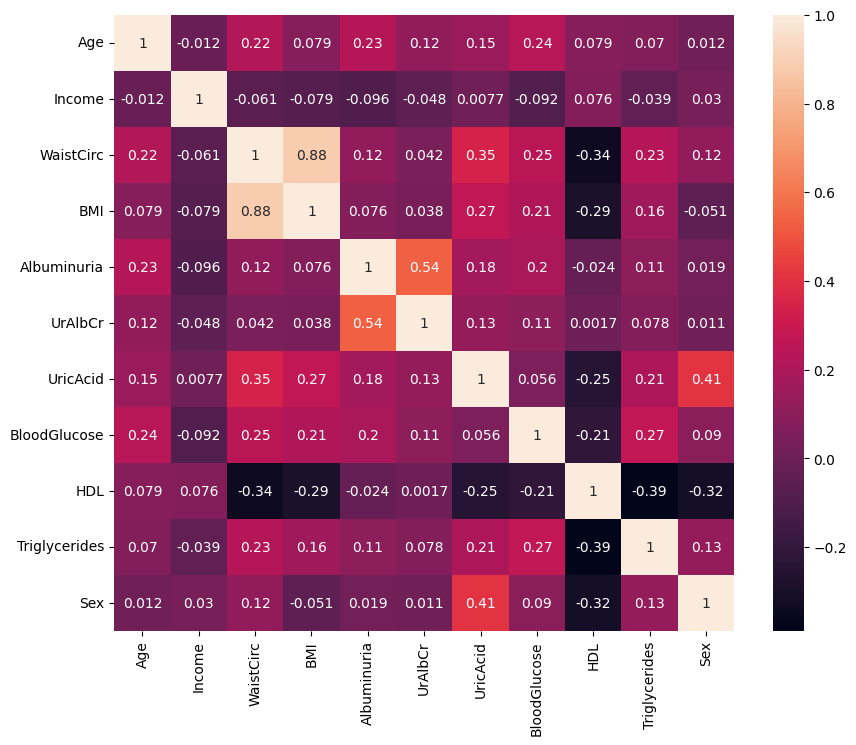

In [95]:
correlation_matrix = features.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

Inference: We can see that 'Sex' has a decent correlation with 'UricAcid' & 'HDL'. 

Now we use the CorrelationRemover class to remove this correlation.

In [96]:
cr = CorrelationRemover(sensitive_feature_ids=["Sex"])
feat_cr = cr.fit_transform(features)
feat_cr = pd.DataFrame(feat_cr, columns=['Age', 'Income', 'WaistCirc', 'BMI', 'Albuminuria', 'UrAlbCr', 'UricAcid', 'BloodGlucose', 'HDL', 'Triglycerides'])
feat_cr["Sex"] = features["Sex"]

cr_alpha = CorrelationRemover(sensitive_feature_ids=["Sex"], alpha=0.5)
feat_cr_alpha = cr_alpha.fit_transform(features)
feat_cr_alpha = pd.DataFrame(
    feat_cr_alpha, columns=['Age', 'Income', 'WaistCirc', 'BMI', 'Albuminuria', 'UrAlbCr', 'UricAcid', 'BloodGlucose', 'HDL', 'Triglycerides']
)
feat_cr_alpha["Sex"] = features["Sex"]

C:\Users\vinay\AppData\Local\Temp\ipykernel_26172\4211561167.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target"] = data['MetabolicSyndrome']


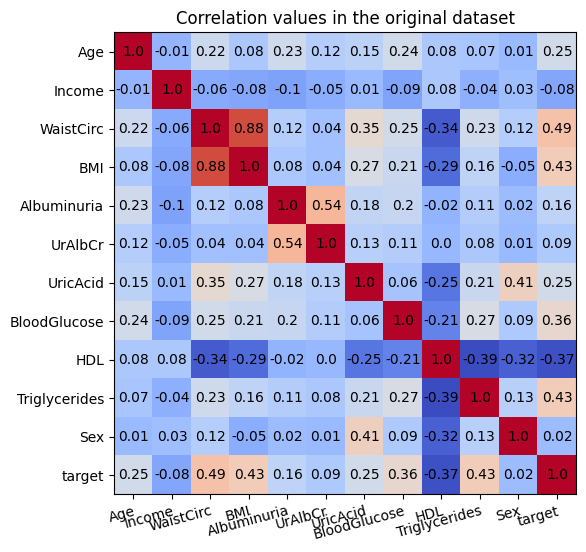

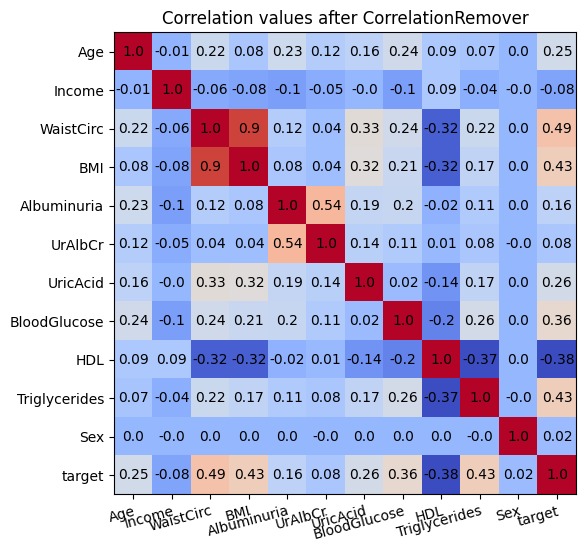

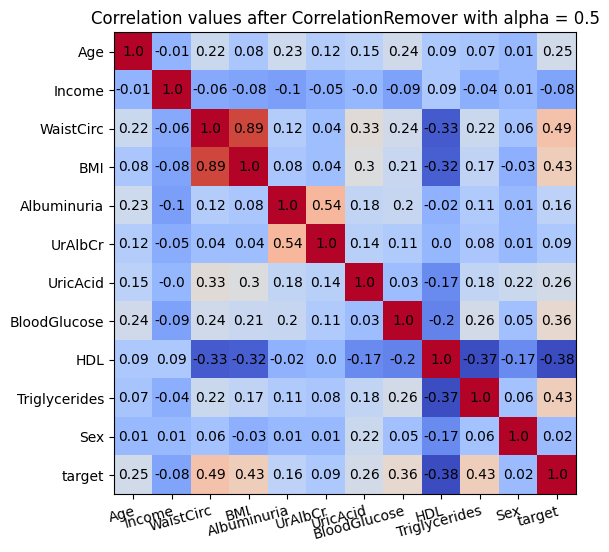

In [97]:
def plot_heatmap(df, title):
    df["target"] = data['MetabolicSyndrome']
    cols = list(df.columns)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(round(df.corr(), 2), cmap="coolwarm")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(cols)))
    ax.set_xticklabels(cols)
    ax.set_yticks(np.arange(len(cols)))
    ax.set_yticklabels(cols)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=15, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(cols)):
        for j in range(len(cols)):
            ax.text(
                j,
                i,
                round(df.corr().to_numpy()[i, j], 2),
                ha="center",
                va="center",
            )

    ax.set_title(f"{title}")
    plt.show()


plot_heatmap(features, "Correlation values in the original dataset")
plot_heatmap(feat_cr, "Correlation values after CorrelationRemover")
plot_heatmap(feat_cr_alpha, "Correlation values after CorrelationRemover with alpha = 0.5")

We can see that using the class's methods we were able to remove the correlation completely. But if we wanted to retain some correlation we can set the alpha value for that case.

This class and its methods only works with the columns passed as 'sensitive_feature_ids' as we can see that rest of the correlation matrix is similar to the one we created before.

Deduction: This class and its methods can be used to remove correlation among features not just sensitive features. 

<function matplotlib.pyplot.show(close=None, block=None)>

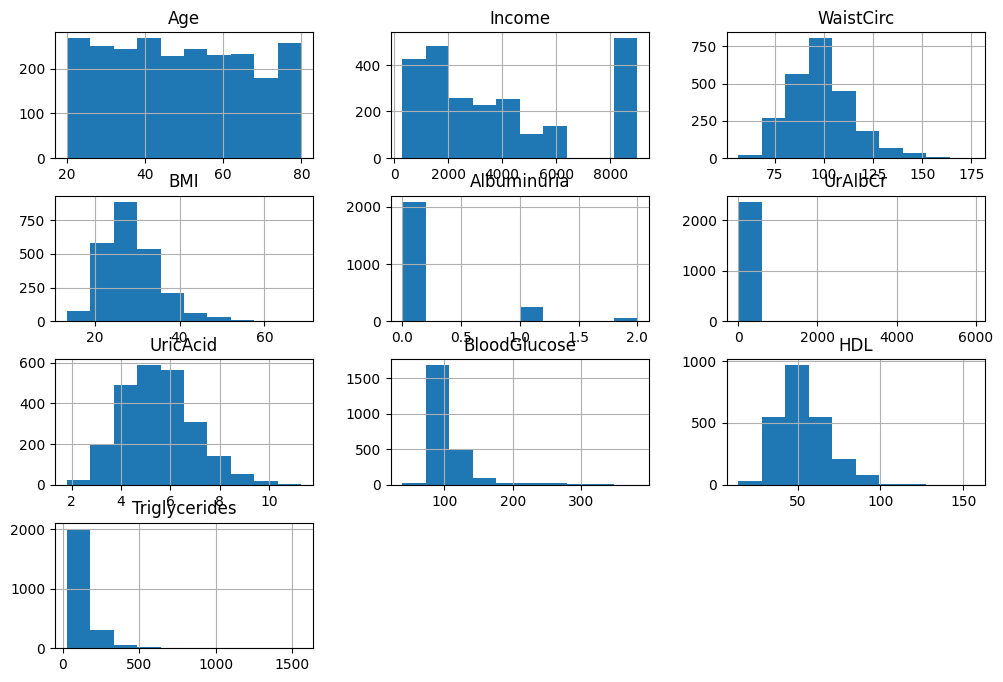

In [98]:
features=features.drop(["target", 
               "Sex"], axis=1)
features.hist(bins =10 , figsize = (12,8))
plt.show 

Inference: 'Age' follows a balanced distribution while 'Income' has a whole set of values(>7000) viewed as outlier. But since there are 3/4th of the values lying in the first half this outlier helps in managing the mean rather than acting as a skewed metric. All the other features follow a Normal Distribution therefore we are not required to do any significant preprocessing on the data.

<Figure size 600x500 with 0 Axes>

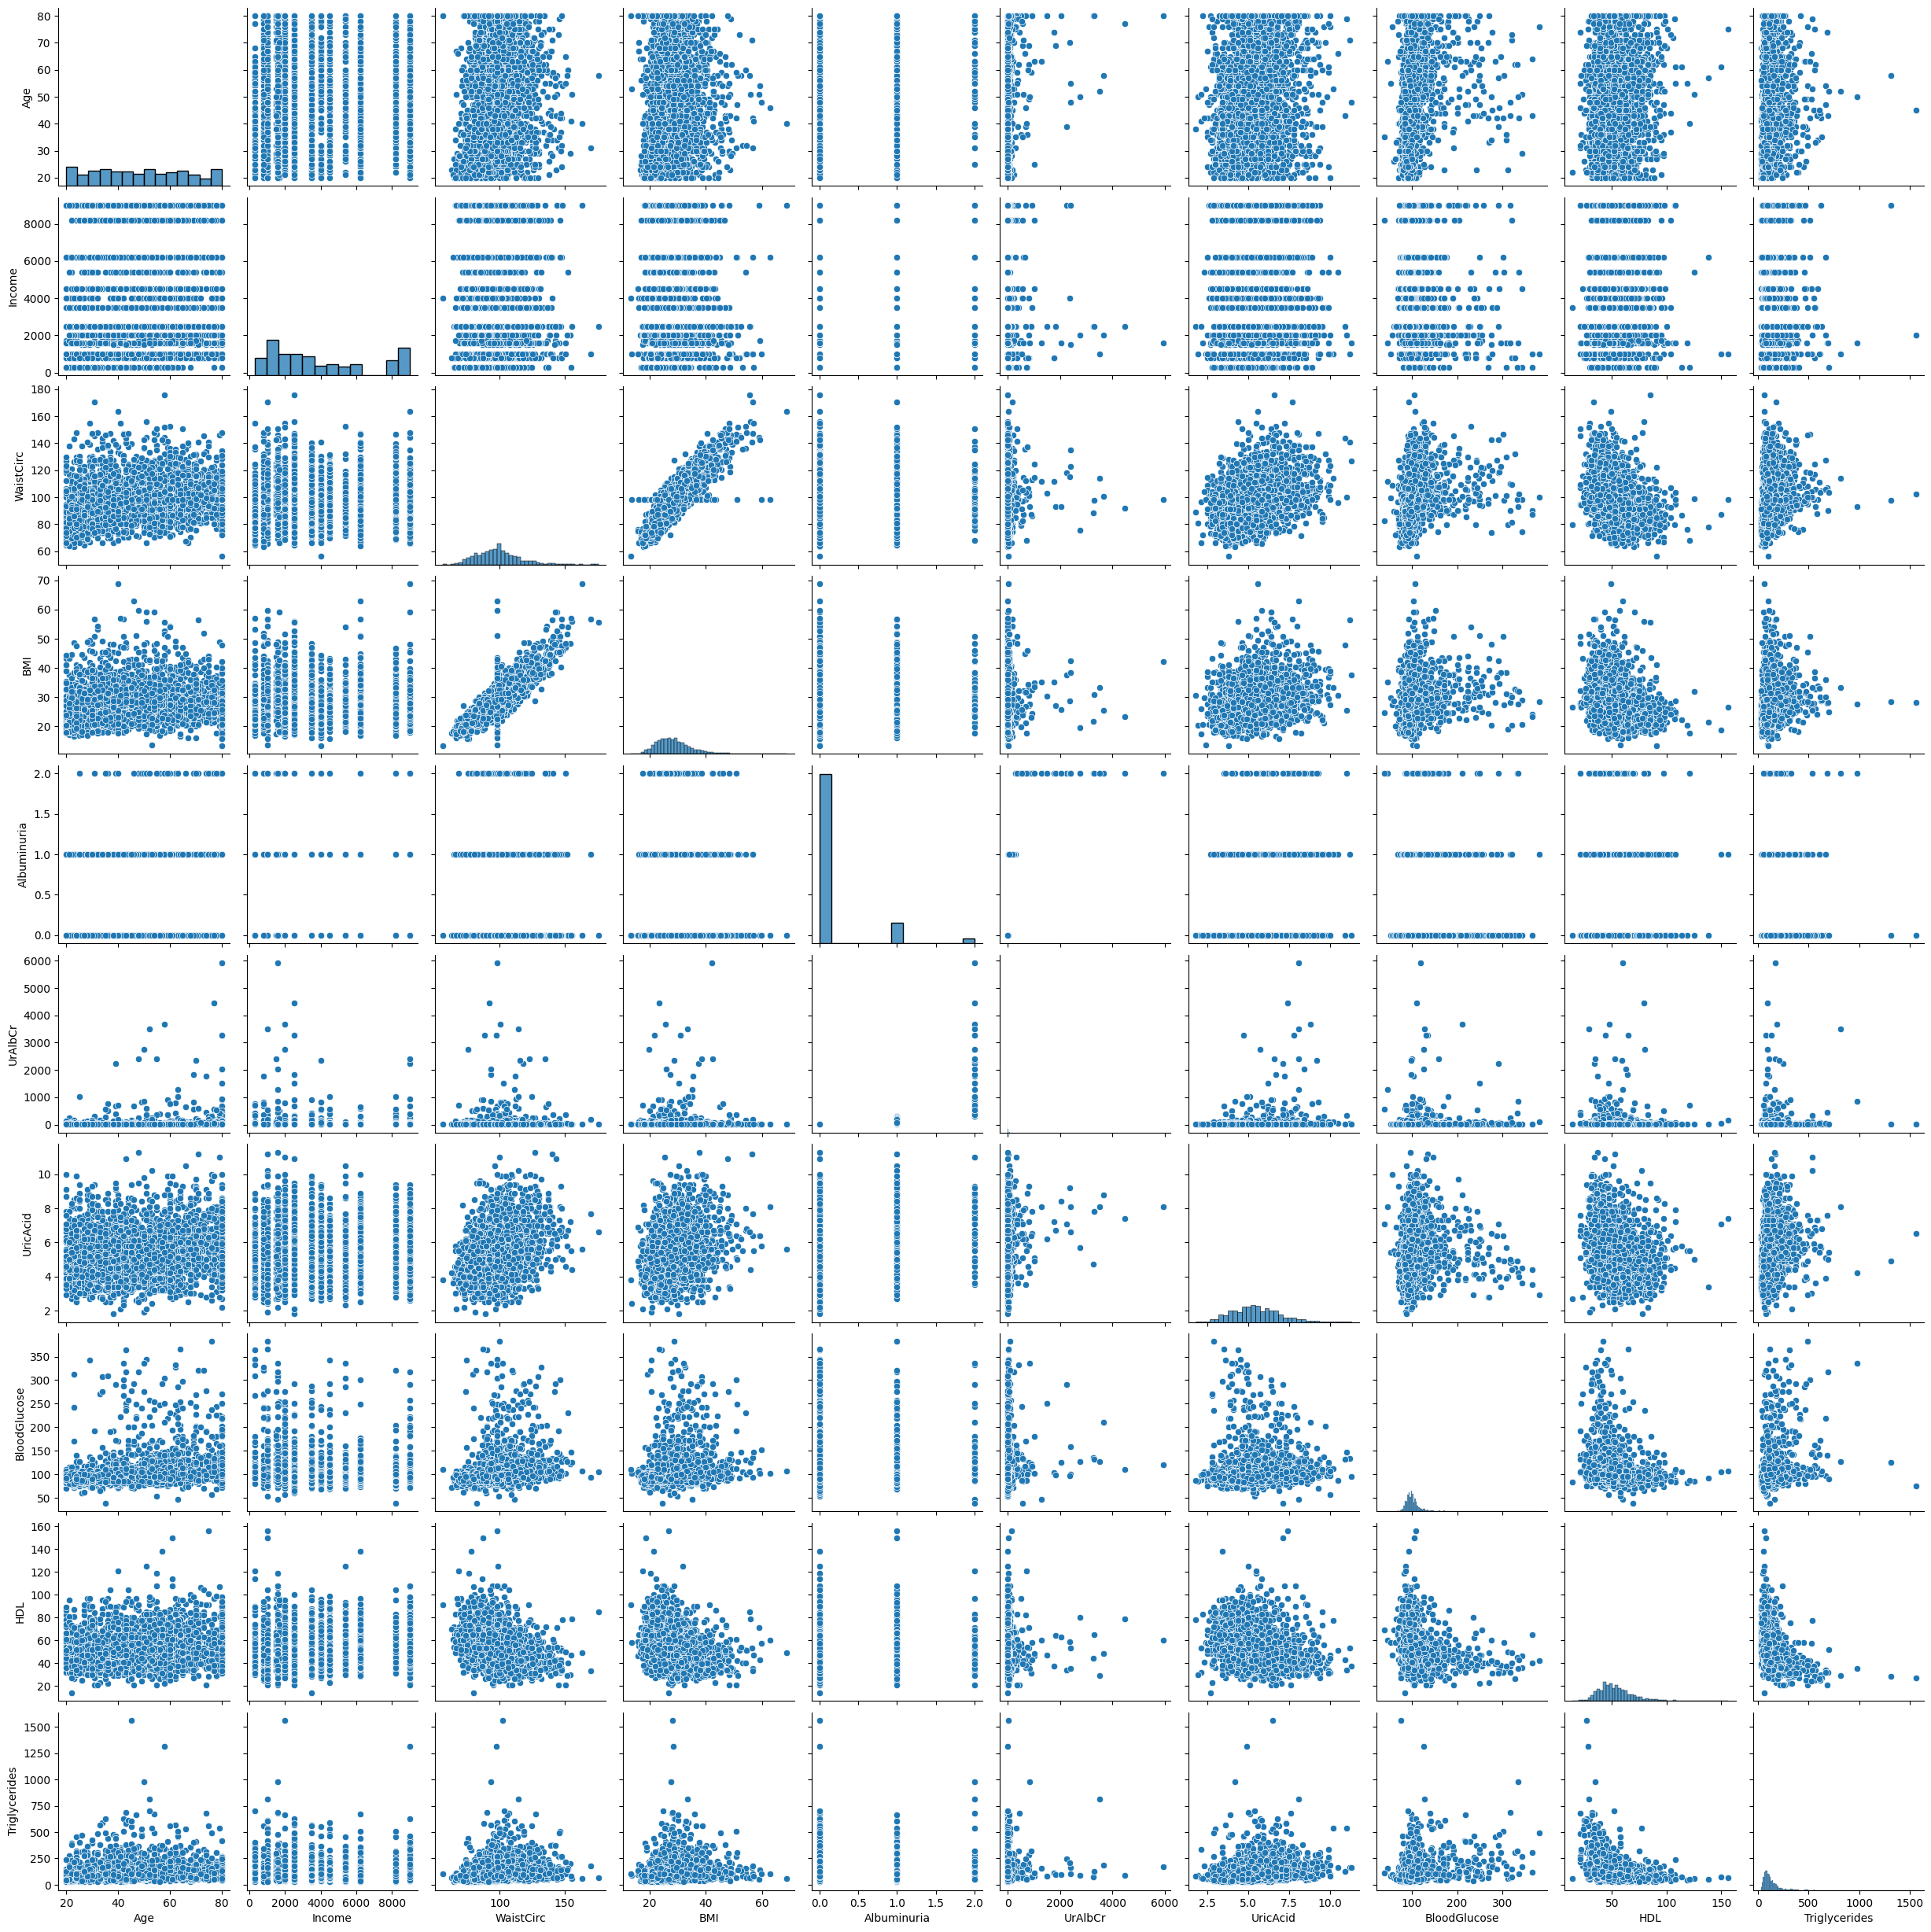

In [99]:
plt.figure(figsize=(6,5))
sns.pairplot(data=features)
plt.show()

7) Standardizing and scaling the values for Logistic Regression.

In [100]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

In [101]:
X = scaled_data
y = data['MetabolicSyndrome']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
sensitive_train, sensitive_test=train_test_split(sensitive_data,test_size=0.2,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape,sensitive_train,sensitive_test

((1920, 10),
 (481, 10),
 (1920,),
 (481,),
          Sex         Race  Marital
 174   Female        White  Married
 420     Male        White  Married
 1980  Female        White  Married
 120   Female        Asian  Married
 283   Female        Black  Widowed
 ...      ...          ...      ...
 1638    Male  MexAmerican   Single
 1095    Male        Asian  Married
 1130  Female        White  Married
 1294    Male        Black  Married
 860   Female        White  Married
 
 [1920 rows x 3 columns],
          Sex         Race   Marital
 685     Male        White   Married
 111   Female        White   Widowed
 1512  Female        Black  Divorced
 1651    Male        Black    Single
 741     Male     Hispanic   Married
 ...      ...          ...       ...
 43      Male        White   Married
 2080    Male  MexAmerican    Single
 610     Male     Hispanic   Married
 2320    Male  MexAmerican   Married
 203   Female     Hispanic   Married
 
 [481 rows x 3 columns])

In [102]:
logistic_classifier = LogisticRegression(random_state=42)
logistic_classifier.fit(X_train, y_train)

y_pred = logistic_classifier.predict(X_test)

8) Result of Logistic Regression.

In [103]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[288  36]
 [ 55 102]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86       324
           1       0.74      0.65      0.69       157

    accuracy                           0.81       481
   macro avg       0.79      0.77      0.78       481
weighted avg       0.81      0.81      0.81       481



9) Checking for selection disparity on all sensitive features.

accuracy            0.810811
selection_rate      0.286902
count             481.000000
dtype: float64
                              accuracy  selection_rate  count
Sex    Race        Marital                                   
Female Asian       Divorced   1.000000        0.500000    2.0
                   Married    0.888889        0.277778   18.0
                   Separated       NaN             NaN    NaN
                   Single     1.000000        0.125000    8.0
                   Widowed    0.000000        0.000000    1.0
       Black       Divorced   0.666667        0.111111    9.0
                   Married    0.684211        0.263158   19.0
                   Separated  1.000000        0.000000    1.0
                   Single     0.882353        0.176471   34.0
                   Widowed    0.333333        0.444444    9.0
       Hispanic    Divorced   0.714286        0.285714    7.0
                   Married    0.888889        0.111111    9.0
                   Separated  

array([[<Axes: title={'center': 'accuracy'}, xlabel='Sex,Race,Marital'>],
       [<Axes: title={'center': 'selection_rate'}, xlabel='Sex,Race,Marital'>],
       [<Axes: title={'center': 'count'}, xlabel='Sex,Race,Marital'>]],
      dtype=object)

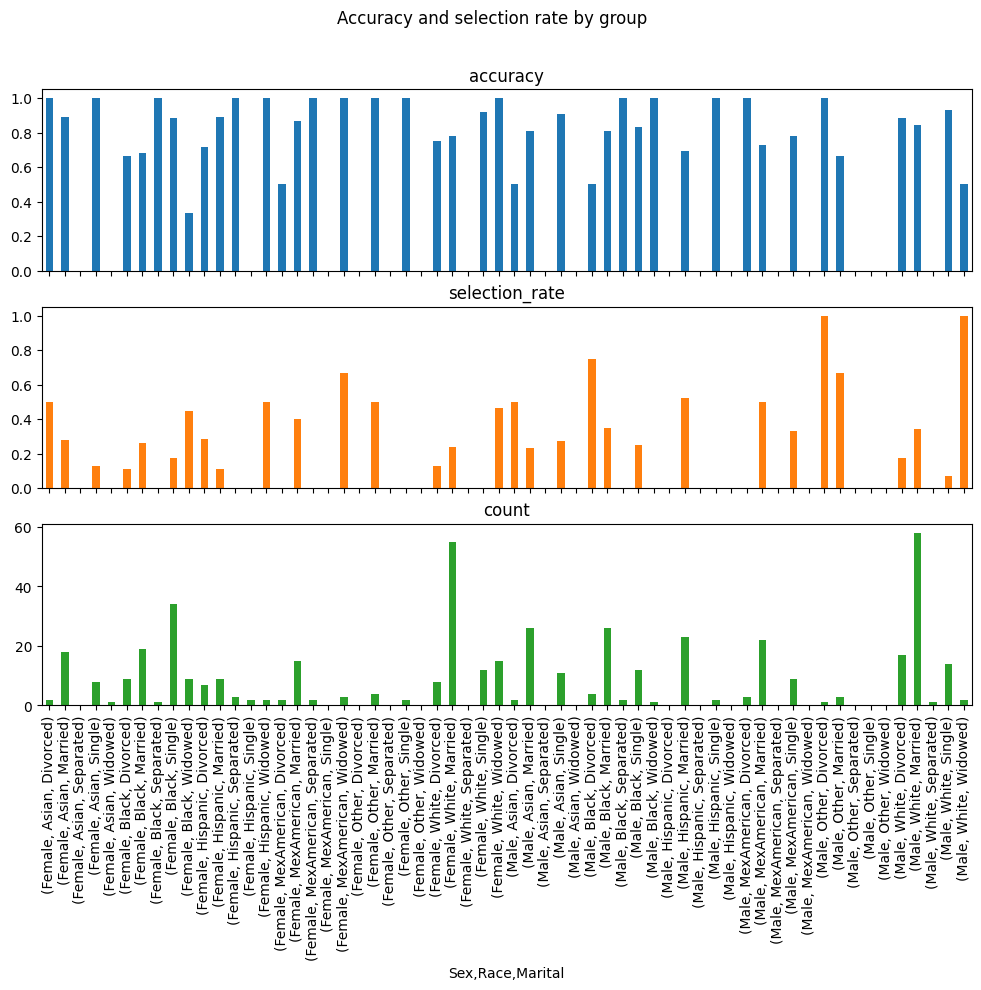

In [104]:
metric_frame = MetricFrame(
    metrics={
        "accuracy": skm.accuracy_score,
        "selection_rate": selection_rate,
        "count": count,
    },
    sensitive_features=sensitive_test,
    y_true=y_test,
    y_pred=logistic_classifier.predict(X_test),
)
print(metric_frame.overall)
print(metric_frame.by_group)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 1],
    legend=False,
    figsize=[12, 8],
    title="Accuracy and selection rate by group",
)

Inference: Our model has a selection rate of 28.6 (Selection rate means for how much population our model is giving a positive result. This means that according to the model 28.6% of our dataset has metabolic syndrome and it does so with 81% accuracy). Overall the model performs decently as the count of (female, white, married) and (male, white, married) are quite high yet it manages the selection rate and gives 80% accuracy for both the groups. 

10) Checking for selection disparity across sensitive features individually.

In [105]:
gender_train = sensitive_train['Sex']
gender_test = sensitive_test['Sex']
race_train = sensitive_train['Race']
race_test = sensitive_test['Race']
marital_train = sensitive_train['Marital']
marital_test = sensitive_test['Marital']

By Race

accuracy            0.810811
selection_rate      0.286902
count             481.000000
dtype: float64
             accuracy  selection_rate  count
Race                                        
Asian        0.852941        0.250000   68.0
Black        0.760684        0.264957  117.0
Hispanic     0.750000        0.333333   48.0
MexAmerican  0.803571        0.392857   56.0
Other        0.900000        0.500000   10.0
White        0.840659        0.258242  182.0


array([[<Axes: title={'center': 'accuracy'}, xlabel='Race'>],
       [<Axes: title={'center': 'selection_rate'}, xlabel='Race'>],
       [<Axes: title={'center': 'count'}, xlabel='Race'>]], dtype=object)

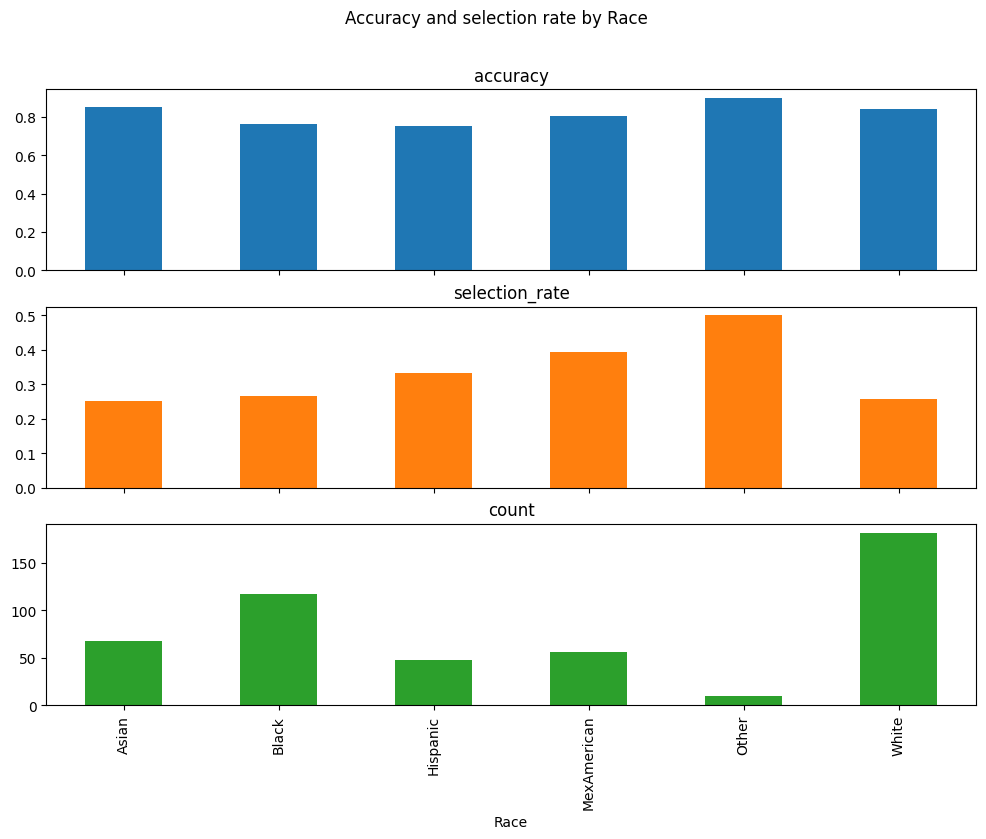

In [106]:
metric_frame = MetricFrame(
    metrics={
        "accuracy": skm.accuracy_score,
        "selection_rate": selection_rate,
        "count": count,
    },
    sensitive_features=race_test,
    y_true=y_test,
    y_pred=logistic_classifier.predict(X_test),
)
print(metric_frame.overall)
print(metric_frame.by_group)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 1],
    legend=False,
    figsize=[12, 8],
    title="Accuracy and selection rate by Race",
)

By Gender

accuracy            0.810811
selection_rate      0.286902
count             481.000000
dtype: float64
        accuracy  selection_rate  count
Sex                                    
Female  0.814050        0.239669  242.0
Male    0.807531        0.334728  239.0


array([[<Axes: title={'center': 'accuracy'}, xlabel='Sex'>],
       [<Axes: title={'center': 'selection_rate'}, xlabel='Sex'>],
       [<Axes: title={'center': 'count'}, xlabel='Sex'>]], dtype=object)

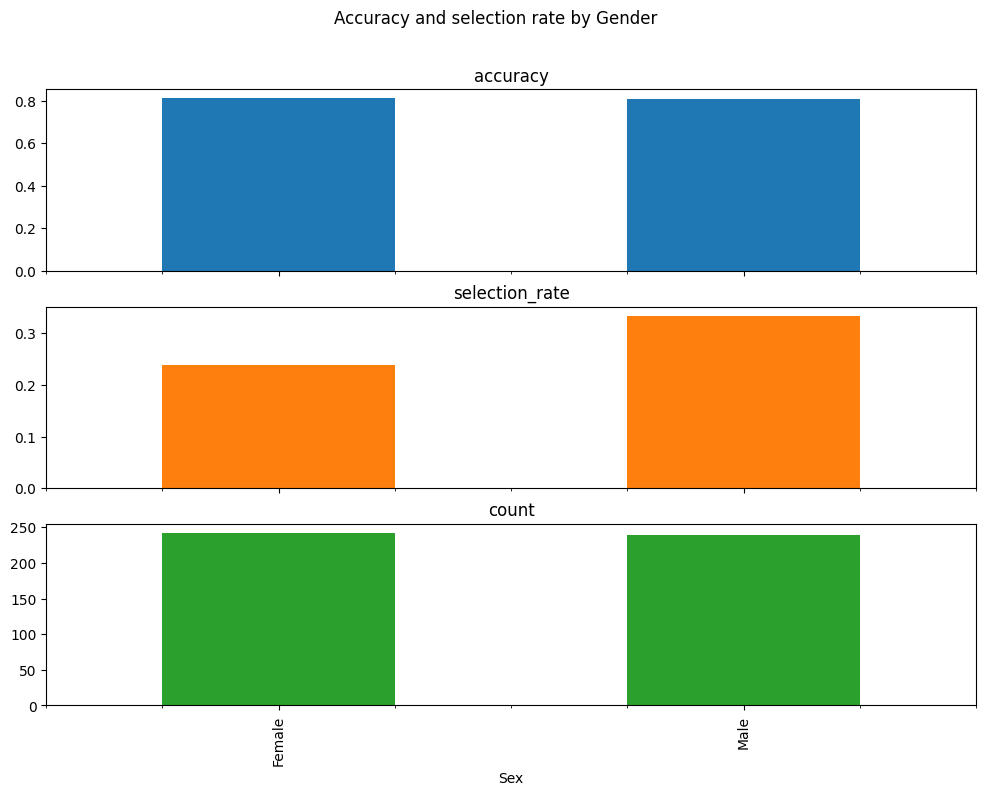

In [107]:
metric_frame = MetricFrame(
    metrics={
        "accuracy": skm.accuracy_score,
        "selection_rate": selection_rate,
        "count": count,
    },
    sensitive_features=gender_test,
    y_true=y_test,
    y_pred=logistic_classifier.predict(X_test),
)
print(metric_frame.overall)
print(metric_frame.by_group)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 1],
    legend=False,
    figsize=[12, 8],
    title="Accuracy and selection rate by Gender",
)

By Marital status

accuracy            0.810811
selection_rate      0.286902
count             481.000000
dtype: float64
           accuracy  selection_rate  count
Marital                                   
Divorced   0.763636        0.236364   55.0
Married    0.798561        0.330935  278.0
Separated  0.888889        0.000000    9.0
Single     0.877358        0.160377  106.0
Widowed    0.757576        0.484848   33.0


array([[<Axes: title={'center': 'accuracy'}, xlabel='Marital'>],
       [<Axes: title={'center': 'selection_rate'}, xlabel='Marital'>],
       [<Axes: title={'center': 'count'}, xlabel='Marital'>]],
      dtype=object)

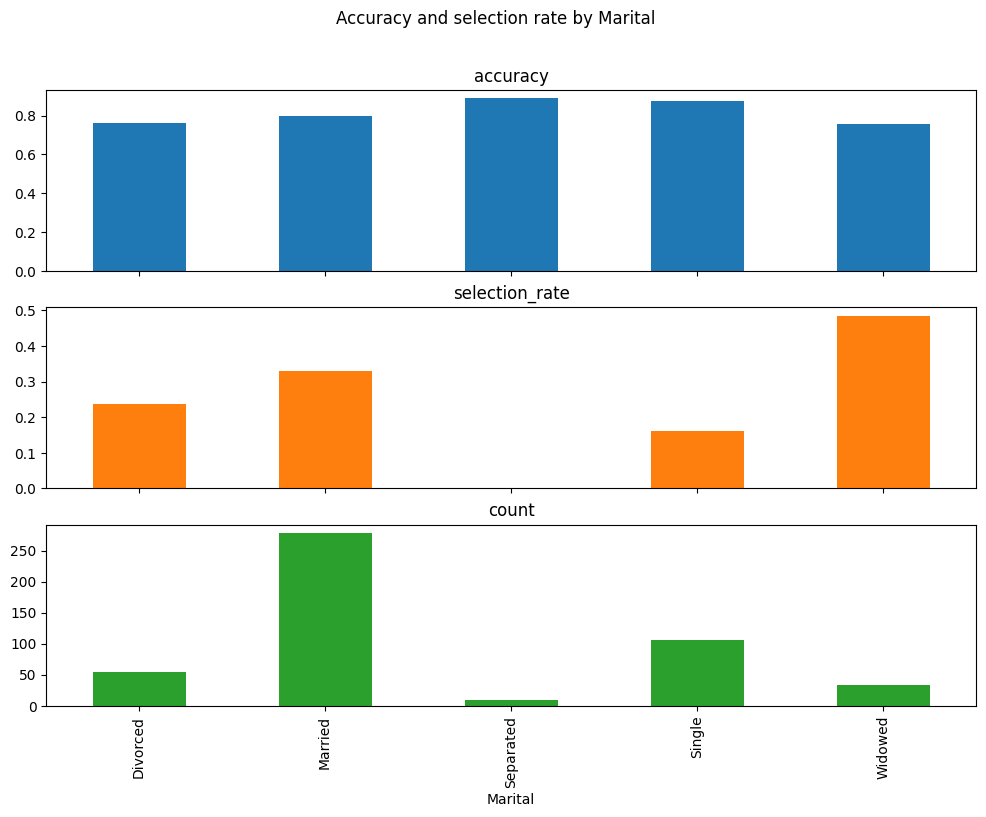

In [108]:
metric_frame = MetricFrame(
    metrics={
        "accuracy": skm.accuracy_score,
        "selection_rate": selection_rate,
        "count": count,
    },
    sensitive_features=marital_test,
    y_true=y_test,
    y_pred=logistic_classifier.predict(X_test),
)
print(metric_frame.overall)
print(metric_frame.by_group)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 1],
    legend=False,
    figsize=[12, 8],
    title="Accuracy and selection rate by Marital",
)

11) Using fairlearn's GridSearch to improve the selection rate and ensure fairness across features.

In [109]:
sweep = GridSearch(
    LogisticRegression(solver="liblinear", fit_intercept=True),
    constraints=DemographicParity(),
    grid_size=31,
)

In [110]:
sweep.fit(X_train, y_train, sensitive_features=gender_train)

predictors = sweep.predictors_

In [111]:
errors, disparities = [], []
for m in predictors:

    def classifier(X):
        return m.predict(X)

    error = ErrorRate()
    error.load_data(X_train, pd.Series(y_train), sensitive_features=gender_train)
    disparity = DemographicParity()
    disparity.load_data(X_train, pd.Series(y_train), sensitive_features=gender_train)

    errors.append(error.gamma(classifier).iloc[0])
    disparities.append(disparity.gamma(classifier).max())

all_results = pd.DataFrame({"predictor": predictors, "error": errors, "disparity": disparities})

non_dominated = []
for row in all_results.itertuples():
    errors_for_lower_or_eq_disparity = all_results["error"][
        all_results["disparity"] <= row.disparity
    ]
    if row.error <= errors_for_lower_or_eq_disparity.min():
        non_dominated.append(row.predictor)

Text(0, 0.5, 'selection rate difference')

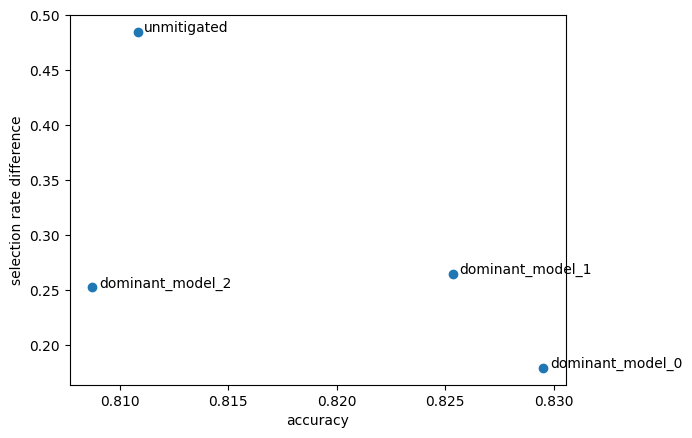

In [112]:
predictions = {"unmitigated": logistic_classifier.predict(X_test)}
metric_frames = {"unmitigated": metric_frame}
for i in range(len(non_dominated)):
    key = "dominant_model_{0}".format(i)
    predictions[key] = non_dominated[i].predict(X_test)

    metric_frames[key] = MetricFrame(
        metrics={
            "accuracy": skm.accuracy_score,
            "selection_rate": selection_rate,
            "count": count,
        },
        sensitive_features=race_test,
        y_true=y_test,
        y_pred=predictions[key],
    )


x = [metric_frame.overall["accuracy"] for metric_frame in metric_frames.values()]
y = [metric_frame.difference()["selection_rate"] for metric_frame in metric_frames.values()]
keys = list(metric_frames.keys())
plt.scatter(x, y)
for i in range(len(x)):
    plt.annotate(keys[i], (x[i] + 0.0003, y[i]))
plt.xlabel("accuracy")
plt.ylabel("selection rate difference")

No matplotlib.Axes object was provided to draw on, so we create a new one


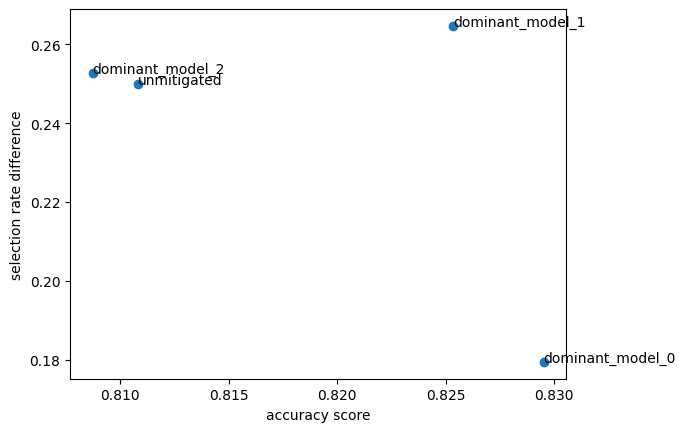

<Axes: xlabel='accuracy score', ylabel='selection rate difference'>

In [113]:
# Plot model comparison
plot_model_comparison(
    x_axis_metric=skm.accuracy_score,
    y_axis_metric=selection_rate_difference,
    y_true=y_test,
    y_preds=predictions,
    sensitive_features=race_test,
    point_labels=True,
    show_plot=True,
)
# End model comparison

We can see that 'unmitigated' which is logistic regression model has accuracy of 81 while the 'dominant_model_0' has an accuracy of ~83 but we cann see that it performs much better than 'unmitigated' model on selection rate difference (Selection Rate Difference means the difference of selection of members belonging to the same group).

Doing the same for Random Forest Classifier.

In [114]:
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [115]:
y_pred = classifier.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[300  24]
 [ 41 116]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.90       324
           1       0.83      0.74      0.78       157

    accuracy                           0.86       481
   macro avg       0.85      0.83      0.84       481
weighted avg       0.86      0.86      0.86       481



Random Forest performs better in accuracy (86.4%) but has a slightly higher selection rate than logistic regression (28.6)

accuracy            0.864865
selection_rate      0.291060
count             481.000000
dtype: float64
                              accuracy  selection_rate  count
Sex    Race        Marital                                   
Female Asian       Divorced   1.000000        0.500000    2.0
                   Married    0.944444        0.222222   18.0
                   Separated       NaN             NaN    NaN
                   Single     1.000000        0.125000    8.0
                   Widowed    0.000000        0.000000    1.0
       Black       Divorced   0.666667        0.111111    9.0
                   Married    0.842105        0.315789   19.0
                   Separated  1.000000        0.000000    1.0
                   Single     0.882353        0.235294   34.0
                   Widowed    0.333333        0.222222    9.0
       Hispanic    Divorced   0.714286        0.285714    7.0
                   Married    0.888889        0.111111    9.0
                   Separated  

array([[<Axes: title={'center': 'accuracy'}, xlabel='Sex,Race,Marital'>],
       [<Axes: title={'center': 'selection_rate'}, xlabel='Sex,Race,Marital'>],
       [<Axes: title={'center': 'count'}, xlabel='Sex,Race,Marital'>]],
      dtype=object)

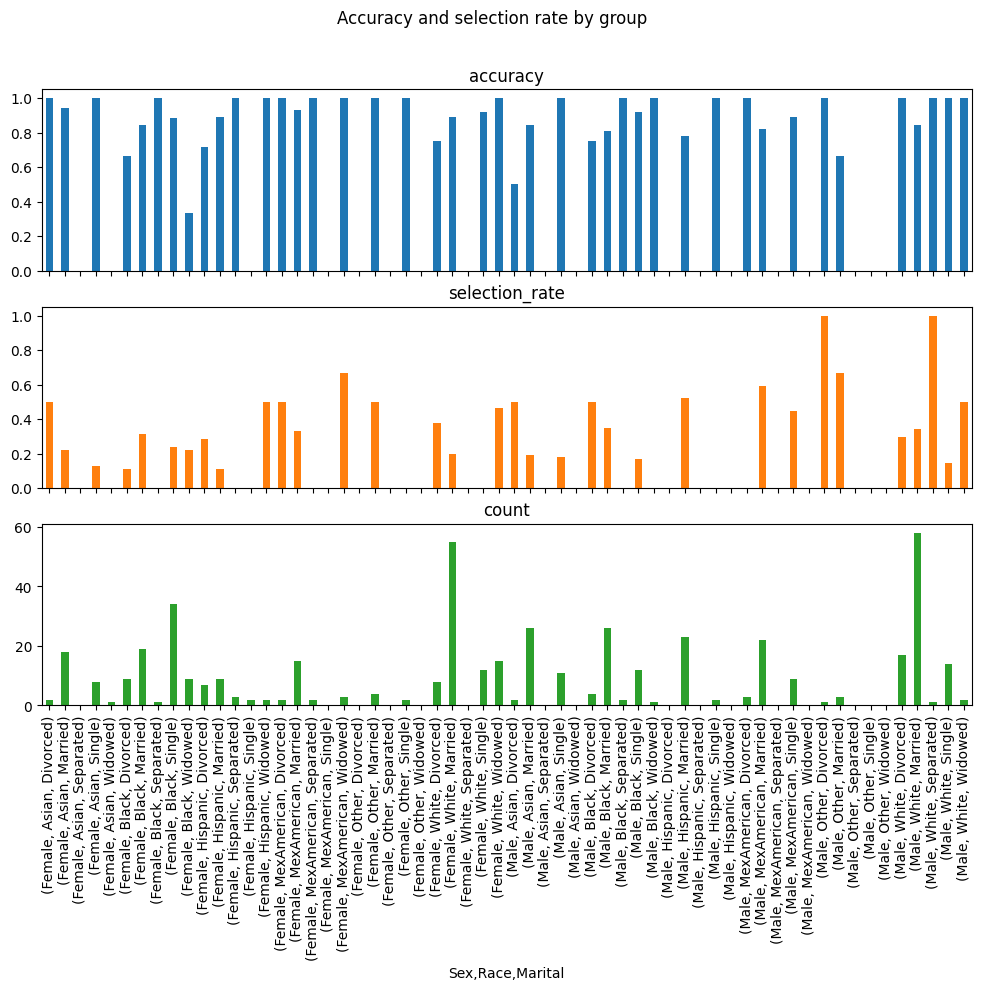

In [117]:
metric_frame = MetricFrame(
    metrics={
        "accuracy": skm.accuracy_score,
        "selection_rate": selection_rate,
        "count": count,
    },
    sensitive_features=sensitive_test,
    y_true=y_test,
    y_pred=classifier.predict(X_test),
)
print(metric_frame.overall)
print(metric_frame.by_group)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 1],
    legend=False,
    figsize=[12, 8],
    title="Accuracy and selection rate by group",
)

Text(0, 0.5, 'selection rate difference')

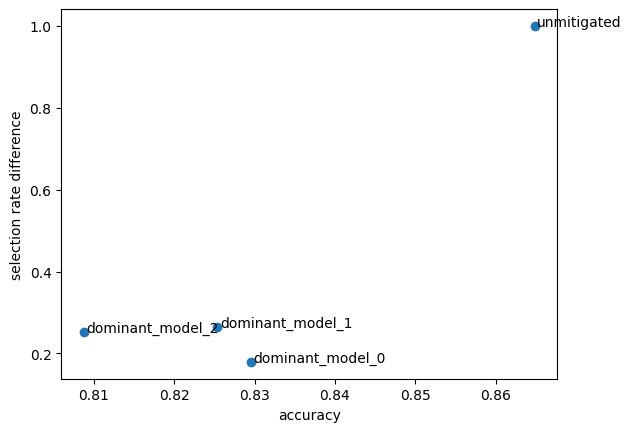

In [118]:
predictions = {"unmitigated": classifier.predict(X_test)}
metric_frames = {"unmitigated": metric_frame}
for i in range(len(non_dominated)):
    key = "dominant_model_{0}".format(i)
    predictions[key] = non_dominated[i].predict(X_test)

    metric_frames[key] = MetricFrame(
        metrics={
            "accuracy": skm.accuracy_score,
            "selection_rate": selection_rate,
            "count": count,
        },
        sensitive_features=race_test,
        y_true=y_test,
        y_pred=predictions[key],
    )


x = [metric_frame.overall["accuracy"] for metric_frame in metric_frames.values()]
y = [metric_frame.difference()["selection_rate"] for metric_frame in metric_frames.values()]
keys = list(metric_frames.keys())
plt.scatter(x, y)
for i in range(len(x)):
    plt.annotate(keys[i], (x[i] + 0.0003, y[i]))
plt.xlabel("accuracy")
plt.ylabel("selection rate difference")

Although 'unmitigated' model (Random Forest Classifier) performs better than all the models suggested by FairLearn but it also has a high selection difference rate.